# Parametrized Quantum Circuit

In classical machine learning, parametric models such as neural networks are trained to approximate unknown functions by minimizing a loss function.
In this notebook, we investigate whether a parameterized quantum circuit (PQC) can play a similar role by approximating a simple continuous function.

Given an input x, an angle between 0 and \pi, approximate the function f(x)=sin(x)

**Goal**

The goal of this notebook is to:
- Construct a parameterized quantum circuit that maps a classical input x to a measurable quantum expectation value
- Train the circuit parameters using a classical optimizer to approximate f(x)=sin(x)
- Analyze the effect of noise, shot count, and circuit depth on training stability

This notebook is not intended to demonstrate quantum advantage, but to illustrate how hybrid quantum–classical models behave under realistic conditions.

The quantum circuit acts as a parametric model, while the optimization loop remains entirely classical.

## Import Libraries

We begin by importing the necessary libraries for our quantum machine learning experiment:
- **Qiskit**: Core quantum computing framework for building and simulating quantum circuits
- **Qiskit Aer**: High-performance simulator backend for running quantum circuits
- **Qiskit Primitives**: StatevectorEstimator for computing expectation values analytically
- **NumPy & Matplotlib**: For numerical computation and visualization
- **SciPy**: For classical optimization algorithms

These tools enable us to construct a hybrid quantum-classical workflow.

In [11]:
# Quantum computing framework
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.primitives import StatevectorEstimator


# Classical computation and utilities
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize


print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Dataset Definition

**Goal**: Create a training dataset consisting of input-output pairs (x, sin(x)).

We generate 100 evenly spaced points between 0 and π using `np.linspace()`. For each input value x, the target output is f(x) = sin(x).

This dataset will be used to train our parameterized quantum circuit to learn the sine function through optimization.

In [12]:
x=np.linspace(0,np.pi,100)
y_target=np.sin(x)

## Input Encoding

**Goal**: Map classical data into quantum states.

The classical input variable x is encoded into a quantum state using **angle encoding**.
Specifically, we apply a rotation around the Y-axis of the Bloch sphere: **Ry(x)**.

This encoding transforms the classical input into a quantum superposition state:
- When x = 0: the qubit remains in state |0⟩
- When x = π: the qubit is rotated to state |1⟩
- For intermediate values: the qubit is in a superposition

The classical input variable x is encoded into a quantum state using angle encoding.
Specifically, we apply a rotation around the Y-axis of the Bloch sphere, Ry(X)

**Limitation**: This encoding is efficient for low-dimensional inputs but does not scale efficiently to high-dimensional data, highlighting one of the main challenges in quantum machine learning.

In [13]:
def pqc_circuit(x, theta):
    """
    Parameterized Quantum Circuit for function approximation.
    
    Parameters:
        x     : float   - input value
        theta : array   - trainable parameters
        
    Returns:
        QuantumCircuit
    """
    qc = QuantumCircuit(1)
    
    # --- Input encoding ---
    qc.ry(x, 0)
    
    # --- Trainable parameters ---
    qc.ry(theta[0], 0)
    qc.rz(theta[1], 0)
    
    return qc


### Parameterized Quantum Circuit (PQC) Definition

**Goal**: Build a quantum circuit with trainable parameters.

The circuit consists of:
1. **Input encoding layer**: Ry(x) - encodes the classical input
2. **Trainable parameter layers**: 
   - Ry(θ₀) - rotation controlled by learnable parameter θ₀
   - Rz(θ₁) - rotation controlled by learnable parameter θ₁

These parameters (θ₀, θ₁) will be optimized to minimize the difference between the circuit's output and sin(x).

The circuit is kept shallow (only 1 qubit, 3 gates) for pedagogical clarity.

## Observable Definition

**Goal**: Define what we measure from the quantum circuit.

We measure the **Pauli-Z observable**, which computes the expectation value:
```
⟨Z⟩ = P(|0⟩) - P(|1⟩)
```

This value ranges from -1 to +1:
- ⟨Z⟩ = +1 when the qubit is entirely in state |0⟩
- ⟨Z⟩ = -1 when the qubit is entirely in state |1⟩
- ⟨Z⟩ = 0 for equal superposition

**Why Z?** The Z observable provides a continuous output that naturally maps to the range of sin(x), making it suitable for function approximation tasks.

In [14]:
observable = SparsePauliOp.from_list([("Z", 1.0)])
estimator = StatevectorEstimator()


## Model Prediction (Forward Pass)

**Goal**: Execute the quantum circuit and extract a prediction.

This function performs the forward pass of our quantum machine learning model:
1. Constructs the PQC with input x and parameters θ
2. Runs the circuit using StatevectorEstimator (analytical simulation)
3. Computes the expectation value of the Z observable
4. Returns this expectation value as the model's prediction

This is analogous to the forward pass in a neural network, but using a quantum circuit instead of classical layers.

In [15]:
def model_output(x, theta):
    qc = pqc_circuit(x, theta)
    
    job = estimator.run(
        [(qc, observable)]
    )
    
    result = job.result()
    expectation_value = result[0].data.evs
    
    return expectation_value


## Running the Model (Untrained)

**Goal**: Test the circuit with random initial parameters.

Before training, we initialize the parameters θ randomly and run the model on our dataset.
This gives us a baseline to compare against after optimization.

**Expected result**: The output will not match sin(x) well, as the parameters are random.

In [16]:
x = np.linspace(0, np.pi, 100)
y_target = np.sin(x)

theta_init = np.random.uniform(0, 2*np.pi, size=2)

y_pred = np.array([model_output(xi, theta_init) for xi in x])


### Sanity Check Plot

**Goal**: Visualize the untrained model's output vs. target function.

This plot shows:
- **Blue line**: The target function sin(x)
- **Dashed line**: The PQC output with random parameters

The poor fit confirms that training is necessary to learn the target function.

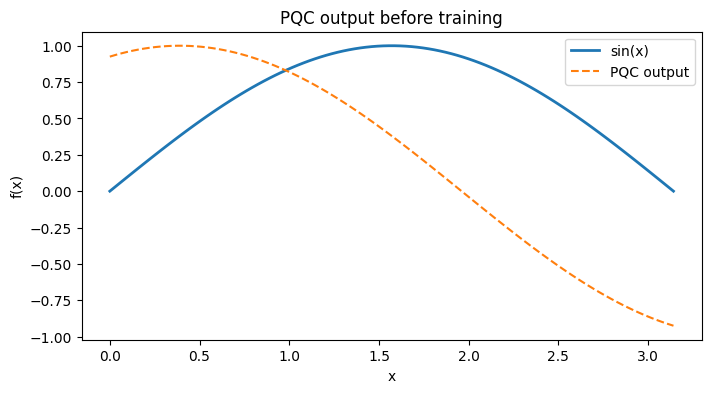

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(x, y_target, label="sin(x)", linewidth=2)
plt.plot(x, y_pred, label="PQC output", linestyle="--")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("PQC output before training")
plt.show()


## Parameter Optimization

**Goal**: Train the quantum circuit to approximate sin(x).

In this section, we use classical optimization to find the best parameters θ that minimize the difference between the circuit's predictions and the target values.

This is the "hybrid" part of hybrid quantum-classical computing: quantum circuits for computation, classical algorithms for optimization.

### Loss Function

**Goal**: Define a metric to quantify prediction accuracy.

We use **Mean Squared Error (MSE)** as our loss function:
```
Loss = (1/N) Σ (y_pred - y_target)²
```

The optimizer will adjust θ to minimize this loss, forcing the circuit's output to match sin(x) more closely.

Lower loss = better approximation.

In [18]:
def loss_function(theta, x_data, y_target):
    """
    Mean Squared Error loss over the dataset.
    
    Parameters:
        theta     : array of trainable parameters
        x_data    : array of input values
        y_target  : array of target values (sin(x))
        
    Returns:
        float - MSE loss
    """
    y_pred = np.array([model_output(xi, theta) for xi in x_data])
    loss = np.mean((y_pred - y_target) ** 2)
    return loss


### Running the Optimizer

**Goal**: Find optimal parameters θ through iterative optimization.

We use the **COBYLA** (Constrained Optimization BY Linear Approximation) algorithm:
- A derivative-free optimizer (doesn't need gradients)
- Well-suited for noisy objective functions
- Maximum 100 iterations

The optimizer repeatedly:
1. Evaluates the loss for current parameters
2. Adjusts parameters to reduce loss
3. Repeats until convergence or max iterations

**Note**: `disp=True` shows optimization progress.

In [19]:
theta_init = np.random.uniform(0, 2 * np.pi, size=2)

result = minimize(
    fun=loss_function,
    x0=theta_init,
    args=(x, y_target),
    method="COBYLA",
    options={"maxiter": 100, "disp": True}
)

theta_opt = result.x


Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 26   Least value of F = 7.178508597170277e-11
The corresponding X is: [4.7124009  2.01916601]



### Trained Model Evaluation

**Goal**: Test the optimized circuit on the full dataset.

Now that we have optimal parameters θ_opt, we run the circuit on all data points to see how well it learned the sine function.

We expect significantly better agreement with sin(x) compared to the untrained model.

In [20]:
y_pred_opt = np.array([model_output(xi, theta_opt) for xi in x])


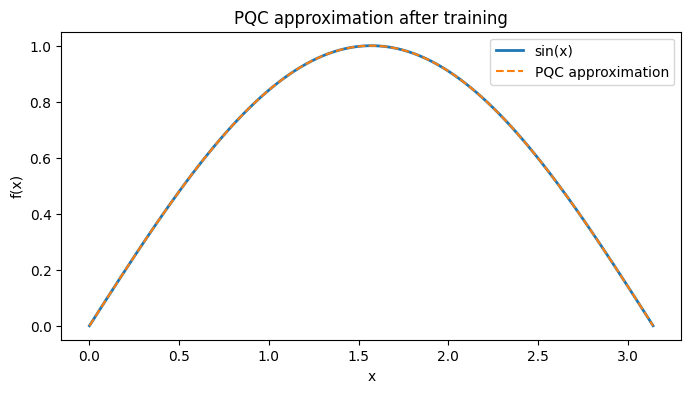

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(x, y_target, label="sin(x)", linewidth=2)
plt.plot(x, y_pred_opt, label="PQC approximation", linestyle="--")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("PQC approximation after training")
plt.show()


### Visualization of Trained Model

**Goal**: Compare the trained PQC approximation with the true sine function.

This plot demonstrates that the quantum circuit successfully learned to approximate sin(x) through optimization.

**Key observation**: The dashed line (PQC output) should closely follow the solid line (true sin(x)).

## Circuit Execution with Finite Shots

**Goal**: Introduce realistic quantum measurement noise.

Until now, expectation values were computed **analytically** using StatevectorEstimator (perfect, noiseless simulation).

On **real quantum hardware**, expectation values must be estimated from a **finite number of measurement shots**, introducing **statistical noise**.

In this section, we:
1. Add explicit measurements to the circuit
2. Run with a limited number of shots (1024)
3. Estimate ⟨Z⟩ from measurement counts
4. Re-train under these noisy conditions

**Why this matters**: Real quantum devices always have finite shot budgets, so understanding shot noise is crucial for practical applications.

In [ ]:
backend = AerSimulator()

def model_output_shots(x, theta, shots=1024):
    qc = QuantumCircuit(1, 1)

    # Encoding
    qc.ry(x, 0)

    # Trainable parameters
    qc.ry(theta[0], 0)
    qc.rz(theta[1], 0)

    # Measurement
    qc.measure(0, 0)

    # Transpile and run
    qc_transpiled = transpile(qc, backend)
    job = backend.run(qc_transpiled, shots=shots)
    counts = job.result().get_counts()

    # Expectation value of Z
    exp_z = 0
    exp_z += counts.get("0", 0)
    exp_z -= counts.get("1", 0)
    exp_z /= shots

    return exp_z

def loss_function_shots(theta, x_data, y_target, shots=1024):
    y_pred = np.array([model_output_shots(xi, theta, shots) for xi in x_data])
    return np.mean((y_pred - y_target) ** 2)

result = minimize(
    fun=loss_function_shots,
    x0=theta_init,
    args=(x, y_target, 1024),
    method="COBYLA",
    options={"maxiter": 100}
)

theta_opt_shots = result.x


### Shot-based Model and Training

**Goal**: Train the circuit with realistic measurement statistics.

Key differences from the analytical version:
1. **Measurement**: Circuit now includes `qc.measure(0, 0)` to collapse the qubit state
2. **Shot-based estimation**: ⟨Z⟩ is computed from counts: (N₀ - N₁) / total_shots
3. **Noisy gradients**: The optimizer sees noisy loss values due to finite sampling

**Trade-off**: More shots = more accurate ⟨Z⟩ estimation, but higher computational cost.

We train with 1024 shots per evaluation, balancing accuracy and efficiency.

In [28]:
theta_opt_shots

array([4.71486626, 1.07322205])

### Optimized Parameters (Shot-based Training)

In [29]:
y_pred_opt = np.array([model_output_shots(xi, theta_opt_shots) for xi in x])

### Generate Predictions with Shot Noise

### Observation: Noisier but More Realistic

**What to expect**: The prediction curve will show more fluctuations compared to the analytical version.

This noise is **statistical** (not an error) - it comes from the finite number of measurements. With more shots, the noise decreases proportionally to 1/√(shots).

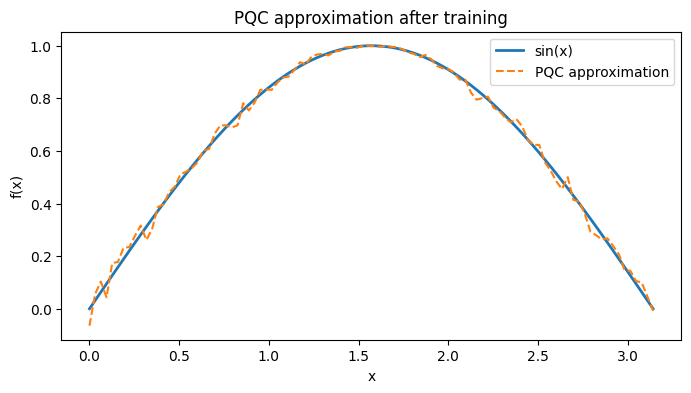

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(x, y_target, label="sin(x)", linewidth=2)
plt.plot(x, y_pred_opt, label="PQC approximation", linestyle="--")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("PQC approximation after training")
plt.show()


### Visualization: Shot-based Approximation

Notice the slight "jitter" in the dashed line - this is the effect of measurement shot noise.

## Circuit Execution with Noise Models

**Goal**: Simulate realistic quantum hardware imperfections.

Beyond shot noise, real quantum devices suffer from:
- **Decoherence**: Loss of quantum information over time
- **Gate errors**: Imperfect implementation of quantum gates
- **Environmental coupling**: Unwanted interactions with surroundings

In this section, we add a **noise model** that simulates these effects using depolarizing errors.

### Why Noise Models Matter

Noise models simulate **decoherence** and **gate errors** present in real quantum devices.

Training variational circuits under noise is a key challenge in **near-term quantum computing** (NISQ era).

Understanding how noise affects learning helps us:
- Design more robust circuits
- Develop error mitigation strategies
- Set realistic expectations for quantum advantage

In [31]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()

error_1q = depolarizing_error(0.01, 1)
error_2q = depolarizing_error(0.02, 2)

noise_model.add_all_qubit_quantum_error(error_1q, ['ry', 'rz'])


### Define Depolarizing Noise Model

**Goal**: Create a noise model with realistic error rates.

**Depolarizing error** models gate imperfections by randomly applying X, Y, or Z errors:
- `error_1q = depolarizing_error(0.01, 1)`: 1% error rate for single-qubit gates
- `error_2q = depolarizing_error(0.02, 2)`: 2% error rate for two-qubit gates

We apply this error to our Ry and Rz gates, simulating imperfect rotations.

**Note**: These error rates are typical for current NISQ devices.

In [33]:
backend_noisy  = AerSimulator()


### Initialize Noisy Backend

Create a simulator backend that will apply our noise model during execution.

In [37]:
def model_output_noisy(x, theta, shots=1024):
    qc = QuantumCircuit(1, 1)

    qc.ry(x, 0)
    qc.ry(theta[0], 0)
    qc.rz(theta[1], 0)

    qc.measure(0, 0)

    # Transpile and run with noise model
    qc_transpiled = transpile(qc, backend_noisy)
    job = backend_noisy.run(qc_transpiled, shots=shots, noise_model=noise_model)

    counts = job.result().get_counts()

    exp_z = counts.get("0", 0) - counts.get("1", 0)
    return exp_z / shots


### Noisy Model Output Function

**Goal**: Execute circuits with both shot noise AND gate errors.

This function combines:
1. **Gate errors**: Applied during circuit execution via `noise_model` parameter
2. **Shot noise**: From finite sampling (1024 shots)

The circuit now experiences realistic quantum hardware conditions, making the optimization problem significantly more challenging.

In [38]:
def loss_function_noisy(theta, x_data, y_target, shots=1024):
    y_pred = np.array([model_output_noisy(xi, theta, shots) for xi in x_data])
    return np.mean((y_pred - y_target) ** 2)


### Loss Function for Noisy Training

Same MSE loss, but now evaluated on noisy circuit outputs.

In [39]:
result_noisy = minimize(
    fun=loss_function_noisy,
    x0=theta_init,
    args=(x, y_target, 1024),
    method="COBYLA",
    options={"maxiter": 100}
)

theta_opt_noisy = result_noisy.x


### Train Under Noisy Conditions

**Goal**: Optimize parameters despite gate errors and shot noise.

This is the most realistic training scenario, representing what happens on actual quantum hardware.

**Expected outcome**: 
- Training will be slower and less stable
- Final approximation quality may be degraded compared to noiseless case
- Demonstrates the challenges of NISQ-era quantum machine learning

In [40]:
y_pred_nois = np.array([model_output_noisy(xi, theta_opt_noisy) for xi in x])

### Generate Noisy Predictions

Evaluate the trained model under noisy conditions across the entire dataset.

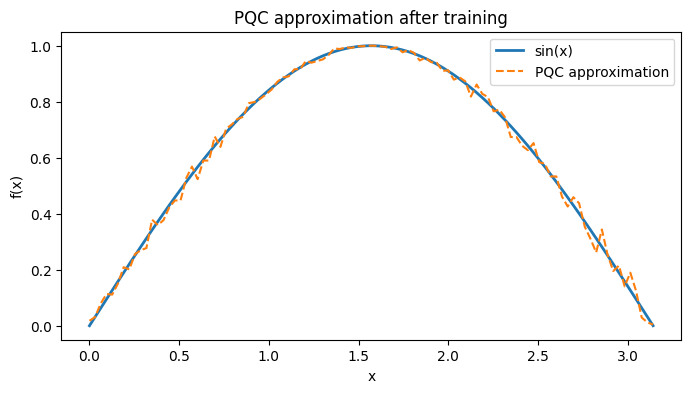

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(x, y_target, label="sin(x)", linewidth=2)
plt.plot(x, y_pred_nois, label="PQC approximation", linestyle="--")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("PQC approximation after training")
plt.show()

### Visualization: Noisy Circuit Approximation

**What to observe**:
- More pronounced fluctuations due to gate errors
- Possible systematic deviations from sin(x)
- The circuit still learns the general shape despite noise

This demonstrates both the robustness and limitations of variational quantum algorithms.

## Conclusions

This experiment demonstrates the **hybrid quantum–classical training loop** under realistic constraints: finite sampling and hardware noise.

### Key Takeaways:

1. **Quantum circuits can learn**: Even simple PQCs can approximate continuous functions through optimization
2. **Shot noise adds variance**: Finite measurements introduce statistical fluctuations that affect training
3. **Gate errors degrade performance**: Hardware imperfections limit expressivity and trainability
4. **NISQ challenges**: Noise motivates ongoing research in:
   - Error mitigation techniques
   - Noise-resilient circuit designs
   - More efficient training algorithms

### Looking Forward:

While simple functions like sin(x) can still be approximated under noise, more complex tasks require:
- Deeper circuits (more parameters)
- Better error correction
- Smarter optimization strategies
- Quantum advantage remains an active area of research

This notebook illustrates the current state of quantum machine learning: promising, but facing significant hardware challenges.